# Testing the PILCO framework

In [1]:
# %load ~/dev/marthaler/header.py
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [2]:
# Enable Float64 for more stable matrix inversions.
import jax
import equinox as eqx
from jax import Array, config
import jax.numpy as jnp
import numpy as np
import jax.random as jr
from jaxtyping import ArrayLike, install_import_hook, Array, Float, Int, PyTree  
import matplotlib as mpl
import matplotlib.pyplot as plt

config.update("jax_enable_x64", True)

key = jr.key(123)

cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

In [3]:
import gymnasium as gym

In [4]:
from controllers import SumOfGaussians
from model_learning.gp_models import MGPR

In [5]:
import optax as ox

from typing import Tuple

In [6]:
from IPython import display

# Functions

In [8]:
def cart_pole_cost(
    states_sequence: ArrayLike, 
    target_state: ArrayLike = jnp.array([0.0,0.0]), 
    lengthscales: ArrayLike = jnp.array([3.0,1.0]),
)->Array:
    """
    Cost function given by the combination of the saturated distance between |theta| and 'target angle', and between x and 'target position'.
    """
    cart_pos = states_sequence[0]
    pole_angle = states_sequence[1]
    cart_velocity = states_sequence[2]
    angle_velocity = states_sequence[3]
    target_theta = 0.0
    target_cart_velocity = 0.0
    target_theta_dot = 0.0

    return 1 - jnp.exp(
        -(jnp.square((pole_angle - target_theta) / lengthscales[0]))  - 
        (jnp.square((angle_velocity-target_theta_dot) / lengthscales[1])) - 
        (jnp.square((cart_velocity-target_cart_velocity) / lengthscales[1]))
    )


In [9]:
def fit_controller(  # noqa: PLR0913
    *,
    policy: eqx.Module,
    samples: ArrayLike,
    timesteps: ArrayLike,
    gp_model: eqx.Module,
    optim: ox.GradientTransformation,
    key: ArrayLike = jr.PRNGKey(42),
    num_iters: int = 100,
    unroll: int = 5,
)->Tuple[eqx.Module,Array]:
    """The optimization loop for fitting the policy parameters."""
    @eqx.debug.assert_max_traces(max_traces=1)
    def rollout(
        policy: eqx.Module,
        init_samples: ArrayLike,
        model: eqx.Module,
        timesteps: ArrayLike,
        key: ArrayLike = jr.key(123),
    )->float:
        policy_params, policy_static = eqx.partition(policy, eqx.is_array)
        
        def one_rollout_step(carry, t):
            policy_params, key, samples, total_cost = carry
            policy = eqx.combine(policy_params, policy_static)
            actions = jax.vmap(policy)(samples,jnp.tile(t,num_particles))
        
            key, subkey = jr.split(key)
            samples = model.get_samples(key, samples, actions, 1)
            cost = jnp.mean(jax.vmap(cart_pole_cost)(jnp.hstack((samples, actions))))
            return (policy_params,key,samples,total_cost+cost), cost
        
        total_cost = 0
        (policy_params,key,samples,total_cost), result = jax.lax.scan(
            one_rollout_step, (policy_params,key,init_samples,total_cost), timesteps
        )
        return total_cost/len(timesteps)
    
    opt_state = optim.init(eqx.filter(policy,eqx.is_array))
    
    # Mini-batch random keys to scan over.
    iter_keys = jr.split(key, num_iters)
    
    # Optimisation step.
    @eqx.filter_jit
    def make_step(
        policy: eqx.Module,
        opt_state: PyTree,
    )->Tuple[eqx.Module,PyTree, float]:
        loss_value, loss_gradient = eqx.filter_value_and_grad(rollout)(policy,samples,gp_model,timesteps)
        updates, opt_state = optim.update(loss_gradient, opt_state, eqx.filter(policy, eqx.is_array))
        policy = eqx.apply_updates(policy, updates)
        return policy, opt_state, loss_value
    
    # Optimisation loop - hack an early stopping criteron
    best_loss: float = float("inf")
    patience: int = 5  # Number of steps of no improvement before stopping
    patience_count: int = 0  # Number of steps since last improving update.
    min_delta: float = (
        1e-3  # Minimum delta between updates to be considered an improvement
    )
    losses = []
    ## Need to apply the dropout schedule...
    for step in range(num_iters):
        policy, opt_state, train_loss = make_step(policy, opt_state)
        losses.append(train_loss)
        # patience_count = jax.lax.select(
        #     best_loss - train_loss > min_delta, 0, patience_count + 1
        # )
        # best_loss = jax.lax.select(train_loss < best_loss, train_loss, best_loss)
        #print(f"{step=}, train_loss={train_loss.item()}, best_loss={best_loss.item()}, ")
        # if patience_count > patience:
        #     print(f"Terminating due to early stopping at {step=}, train_loss={train_loss.item()}, ")
        #     break
        if (step % 100) == 0 or (step == num_iters - 1):
            print(f"{step=}, train_loss={train_loss.item()}, ")

    return policy, jnp.array(losses)

In [32]:
def rollout_check(
    policy: eqx.Module,
    init_samples: ArrayLike,
    model: eqx.Module,
    timesteps: ArrayLike,
    key: ArrayLike = jr.key(123),
)->Tuple[Float, Array]:
    policy_params, policy_static = eqx.partition(policy, eqx.is_array)
    
    def one_rollout_step(carry, t):
        policy_params, key, samples, total_cost = carry
        policy = eqx.combine(policy_params, policy_static)
        actions = jax.vmap(policy)(samples,jnp.tile(t,num_particles))
    
        key, subkey = jr.split(key)
        samples = model.get_samples(key, samples, actions, 1)
        cost = jnp.mean(jax.vmap(cart_pole_cost)(jnp.hstack((samples, actions))))
        return (policy_params,key,samples,total_cost+cost), cost
    
    total_cost = 0
    (policy_params,key,samples,total_cost), result = jax.lax.scan(
        one_rollout_step, (policy_params,key,init_samples,total_cost), timesteps
    )
    return total_cost/len(timesteps), samples

## Globals

In [11]:
num_particles = 400

In [12]:
num_trials = 8
T_sampling = 0.05
T_exploration = 0.35
T_control = 3.0
sim_timestep = 0.01

## Generate the environments

In [13]:
env = gym.make("InvertedPendulum-v5")
env_test = gym.make("InvertedPendulum-v5", render_mode='rgb_array')

In [14]:
action_dim = env.action_space.shape[0]
x, _ = env.reset()
state_dim = x.shape[0]
num_basis = 200
umax = 3.0

In [15]:
# Randomly sample some points
key = jr.key(42)
x, _ = env.reset()
states = [x]
key, subkey = jr.split(key)
u = env.action_space.sample()
actions = [u]

for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
    z = env.step(np.array(u))
    x = z[0]
    states.append(x)
    key, subkey = jr.split(key)
    u = env.action_space.sample()
    actions.append(u)

for _ in range(num_trials-1):
    x, _ = env.reset()
    states.append(x)
    key, subkey = jr.split(key)
    u = env.action_space.sample()
    #u = exploration_policy(x,0,subkey)
    actions.append(u)
    
    for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
        z = env.step(np.array(u))
        x = z[0]
        states.append(x)
        key, subkey = jr.split(key)
        u = env.action_space.sample()
        actions.append(u)
    

In [18]:
model = MGPR(states=jnp.array(states),actions=jnp.array(actions))

In [20]:
%%time
print(-model.build_gp(model.models[0]).log_probability(model.training_outputs[:,0]))
model.optimize()
print(-model.build_gp(model.models[0]).log_probability(model.training_outputs[:,0]))

-179.56894926631782
-179.17940249985287
CPU times: user 2.41 s, sys: 600 ms, total: 3.01 s
Wall time: 1.02 s


In [21]:
st = jnp.array(states)
pm = model.predict_all_outputs(jnp.hstack((st,jnp.array(actions))))

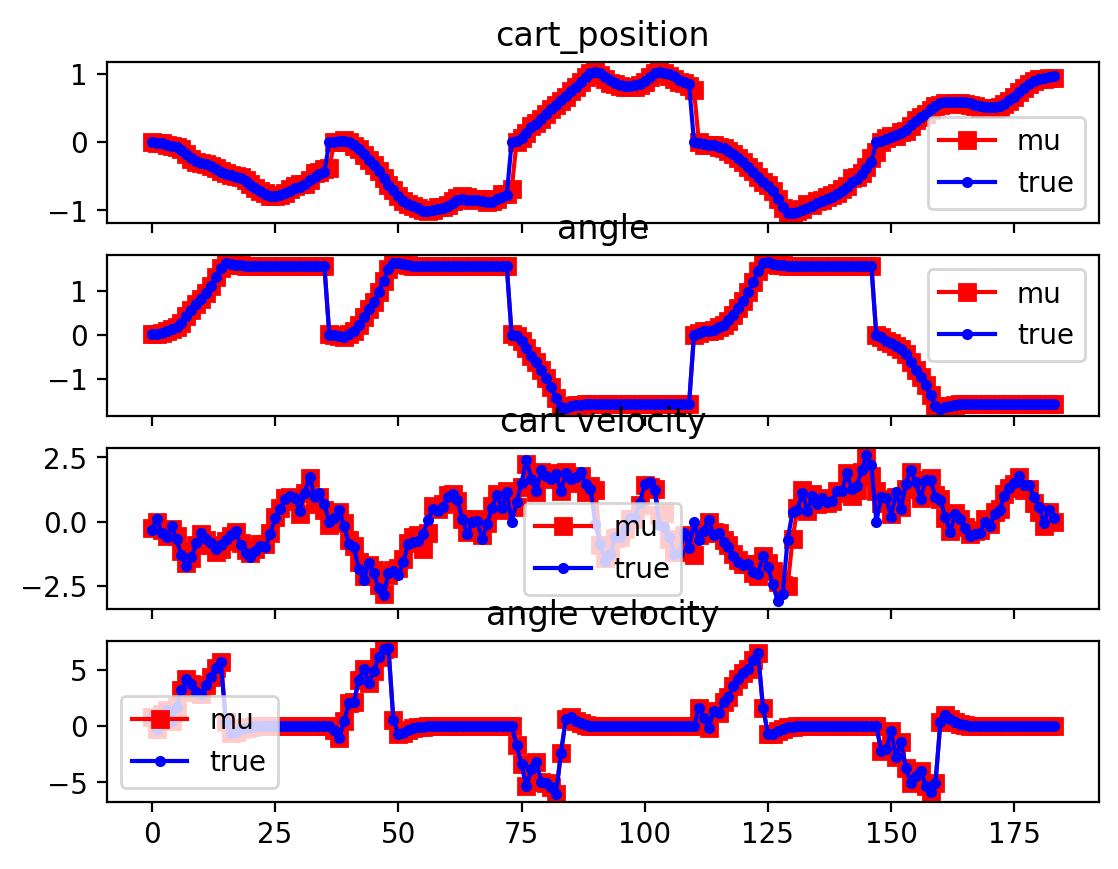

In [22]:
titles = ['cart_position','angle','cart velocity','angle velocity']
fig, ax = plt.subplots(4,1,sharex=True)
for i in range(4):
    ax[i].plot(pm[:-1,i,0],color='red',label='mu',marker='s')
    ax[i].plot(st[1:,i],color='blue',label='true',marker='.')
    ax[i].legend();
    ax[i].set_title(titles[i]);

### Rollout

In [24]:
# Now do a rollout with this model
# Generate an initial state
x, _ = env.reset()
key, subkey = jr.split(key)
# Generate an initial (random) action
u = env.action_space.sample()

In [25]:
# initialize some particles
initial_particles = model.get_samples(key, jnp.array([x]), jnp.array([u]), num_particles)

In [27]:
control_policy = SumOfGaussians(
    state_dim, 
    action_dim, 
    num_basis, 
    initial_log_lengthscales = None,
    initial_centers=None,
    to_squash=True, 
    max_action=umax)

In [28]:
control_horizon = int(T_control/T_sampling)

In [29]:
optimizer = ox.adam(learning_rate=ox.linear_schedule(init_value=1e-2, end_value=1e-6, transition_steps=100))

In [30]:
%%time
control_policy, losses = fit_controller(
    policy=control_policy,
    samples=initial_particles,
    timesteps=jnp.arange(control_horizon),
    gp_model=model,
    optim=optimizer,
    num_iters=250
)

step=0, train_loss=0.9758800890201673, 
step=100, train_loss=0.9961786879974167, 
step=200, train_loss=0.9961783868155368, 
step=249, train_loss=0.9961781079113209, 
CPU times: user 2min 23s, sys: 3min 19s, total: 5min 42s
Wall time: 1min


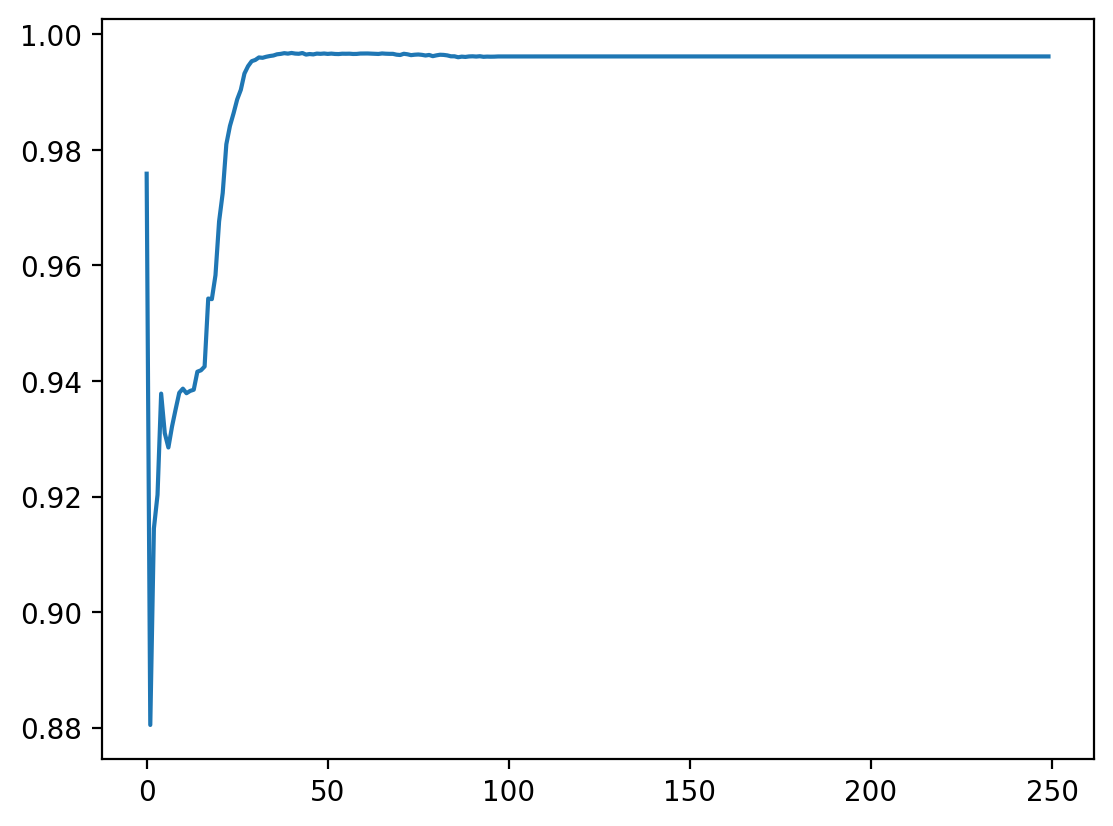

In [31]:
plt.plot(losses)

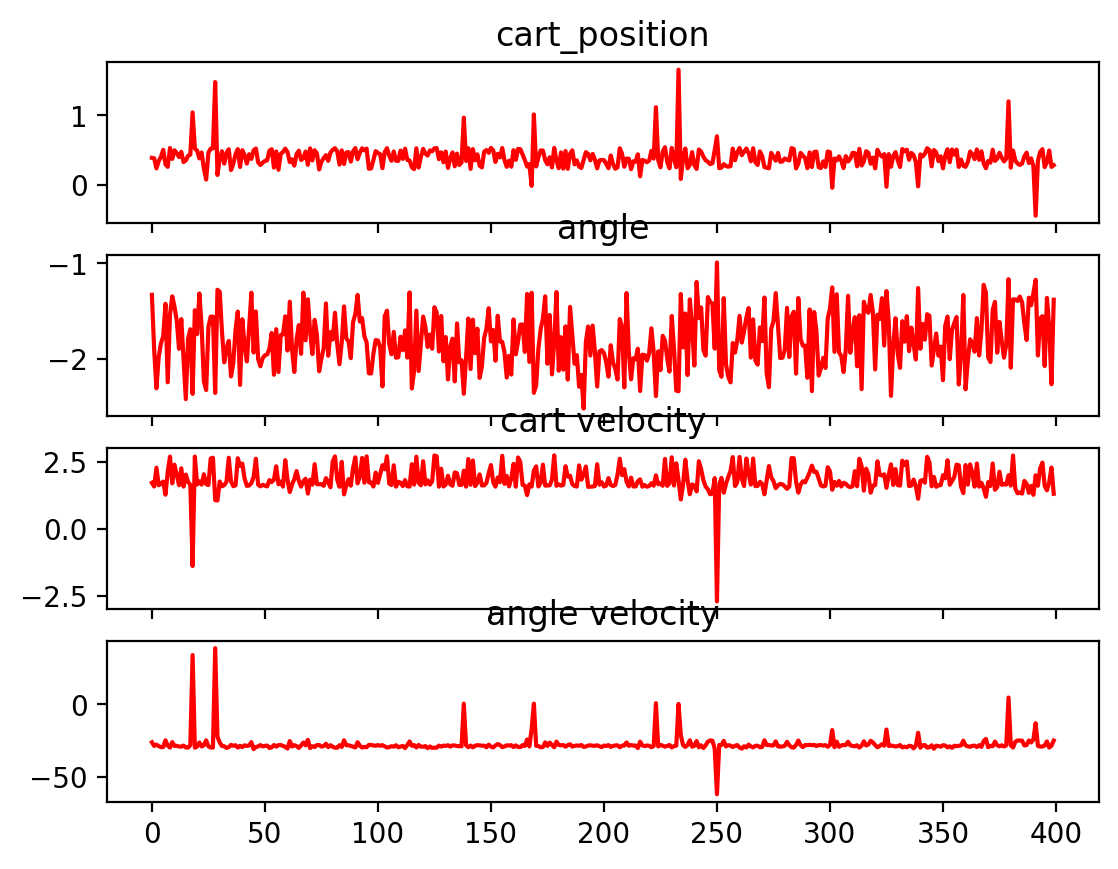

In [38]:
cost, samps = rollout_check(
    control_policy,
    initial_particles,
    model,
    jnp.arange(control_horizon),
)
titles = ['cart_position','angle','cart velocity','angle velocity']
fig, ax = plt.subplots(4,1,sharex=True)
for i in range(4):
    ax[i].plot(samps[:,i],color='red')
    ax[i].set_title(titles[i]);
plt.show()

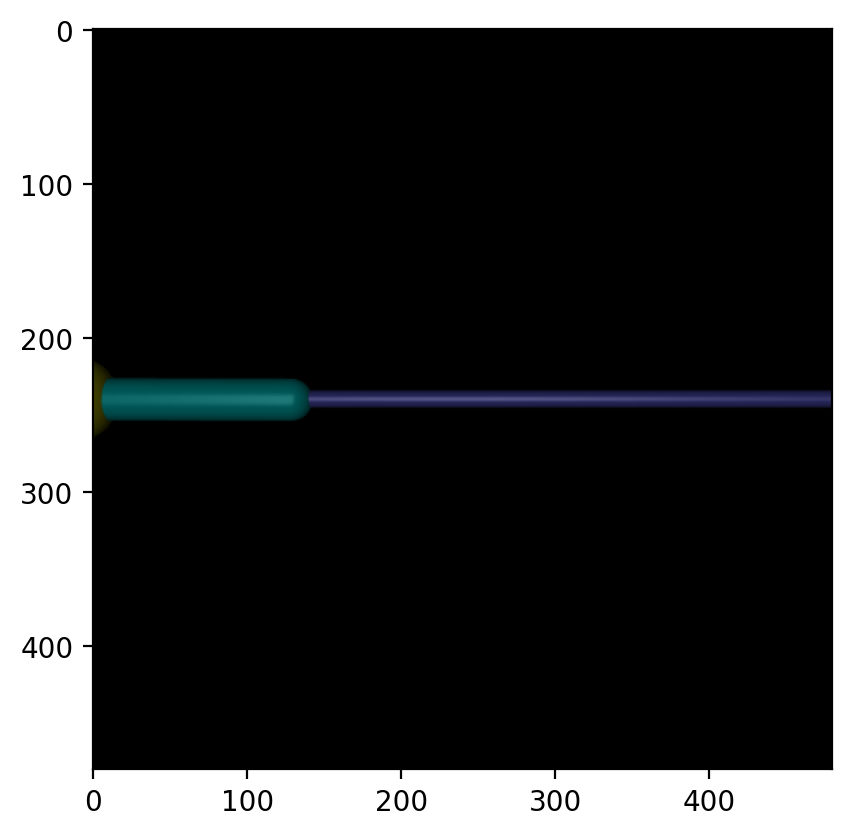

In [40]:
# Now try this policy on the real system
x, _ = env_test.reset()
key, subkey = jr.split(key)
u = control_policy(x,timestep)
# Randomly sample some points
states.append(x)
actions.append(u)
img = plt.imshow(env_test.render()) # only call this once
for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
    z = env_test.step(np.array(u))
    x = z[0]
    r = z[1]
    key, subkey = jr.split(key)
    u = control_policy(x,timestep)
    states.append(x)
    actions.append(u)
    img.set_data(env_test.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [41]:
%%time
model = MGPR(states=jnp.array(states),actions=jnp.array(actions))
print(-model.build_gp(model.models[0]).log_probability(model.training_outputs[:,0]))
model.optimize()
print(-model.build_gp(model.models[0]).log_probability(model.training_outputs[:,0]))

5.759763856650018
-180.14813084206781
CPU times: user 9.29 s, sys: 2.05 s, total: 11.3 s
Wall time: 4.47 s


## Visualize how weell the model is predicting the next state

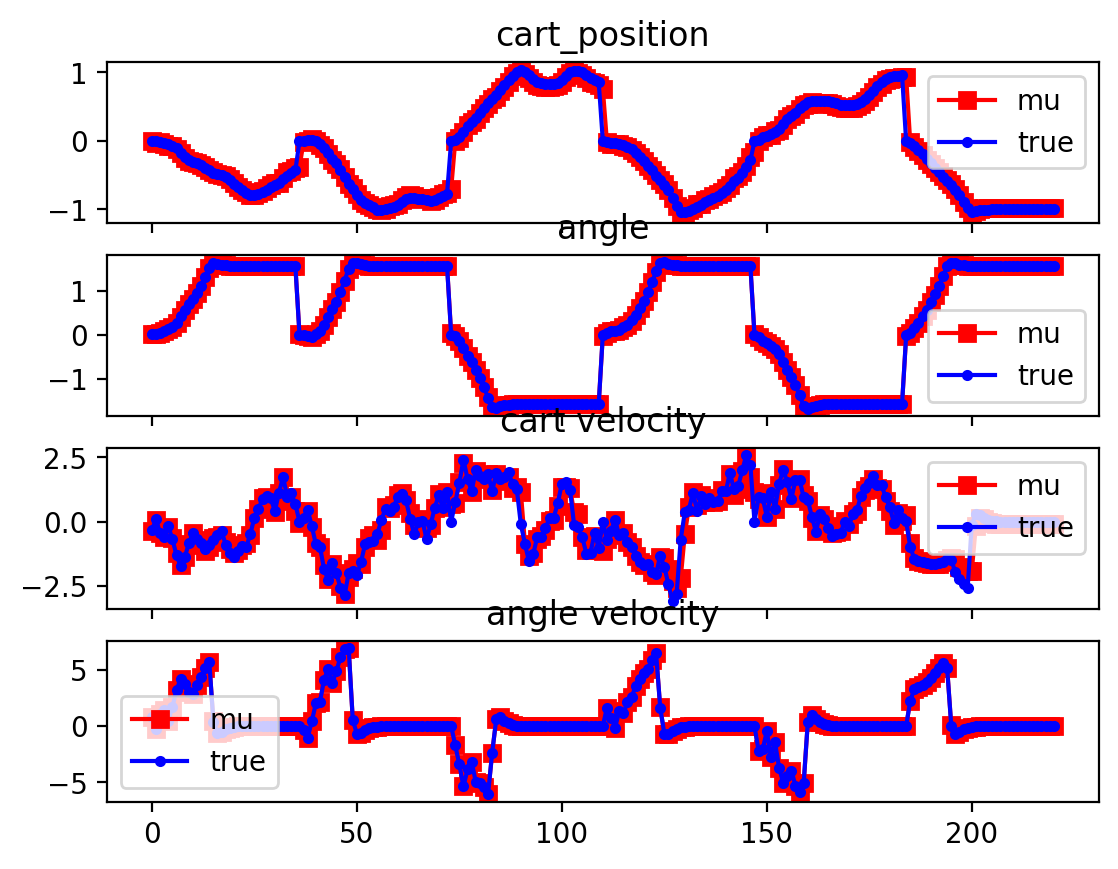

In [42]:
st = jnp.array(states)
pm = model.predict_all_outputs(jnp.hstack((st,jnp.array(actions))))
titles = ['cart_position','angle','cart velocity','angle velocity']
fig, ax = plt.subplots(4,1,sharex=True)
for i in range(4):
    ax[i].plot(pm[:-1,i,0],color='red',label='mu',marker='s')
    ax[i].plot(st[1:,i],color='blue',label='true',marker='.')
    ax[i].legend();
    ax[i].set_title(titles[i]);

In [43]:
# Now do a rollout with this model
# Generate an initial state
x, _ = env.reset()
key, subkey = jr.split(key)
# Generate an initial (action
u = env.action_space.sample()

In [44]:
initial_particles = model.get_samples(key, jnp.array([x]), jnp.array([u]), num_particles)

In [45]:
%%time
control_policy, losses = fit_controller(
    policy=control_policy,
    samples=initial_particles,
    timesteps=jnp.arange(control_horizon),
    gp_model=model,
    optim=optimizer,
    num_iters=250
)

step=0, train_loss=0.9914519499937463, 
step=100, train_loss=0.9621305809277914, 
step=200, train_loss=0.9621295581999907, 
step=249, train_loss=0.9621289707526833, 
CPU times: user 2min 57s, sys: 3min 41s, total: 6min 38s
Wall time: 1min 10s


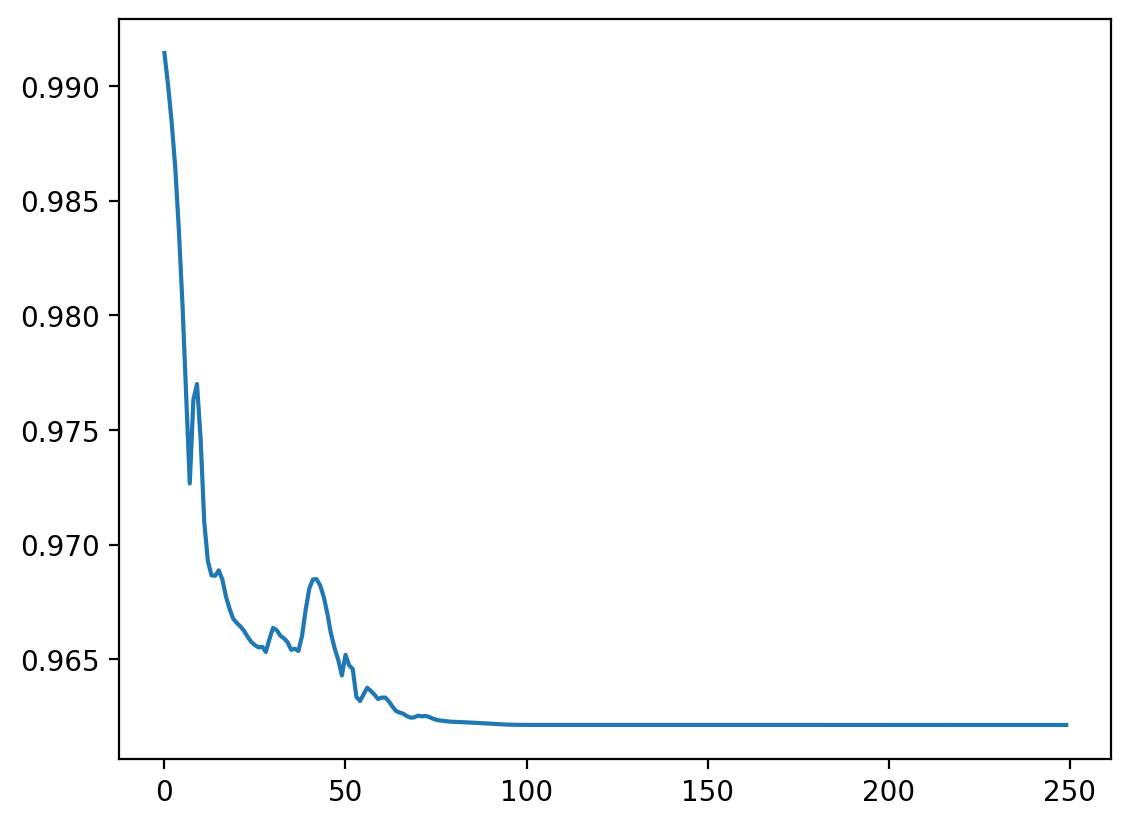

In [48]:
plt.plot(losses)

0.9621289582608609


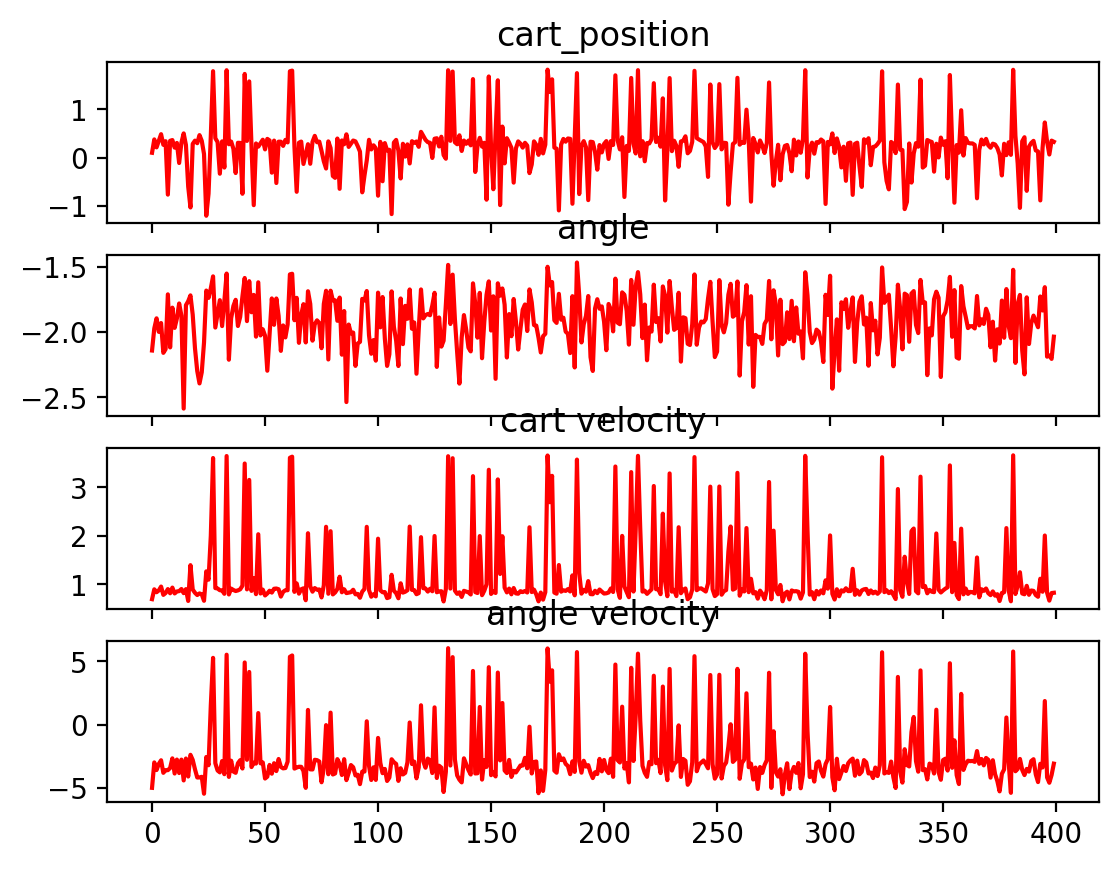

In [50]:
cost, samps = rollout_check(
    control_policy,
    initial_particles,
    model,
    jnp.arange(control_horizon),
)
print(cost)
titles = ['cart_position','angle','cart velocity','angle velocity']
fig, ax = plt.subplots(4,1,sharex=True)
for i in range(4):
    ax[i].plot(samps[:,i],color='red')
    ax[i].set_title(titles[i]);
plt.show()

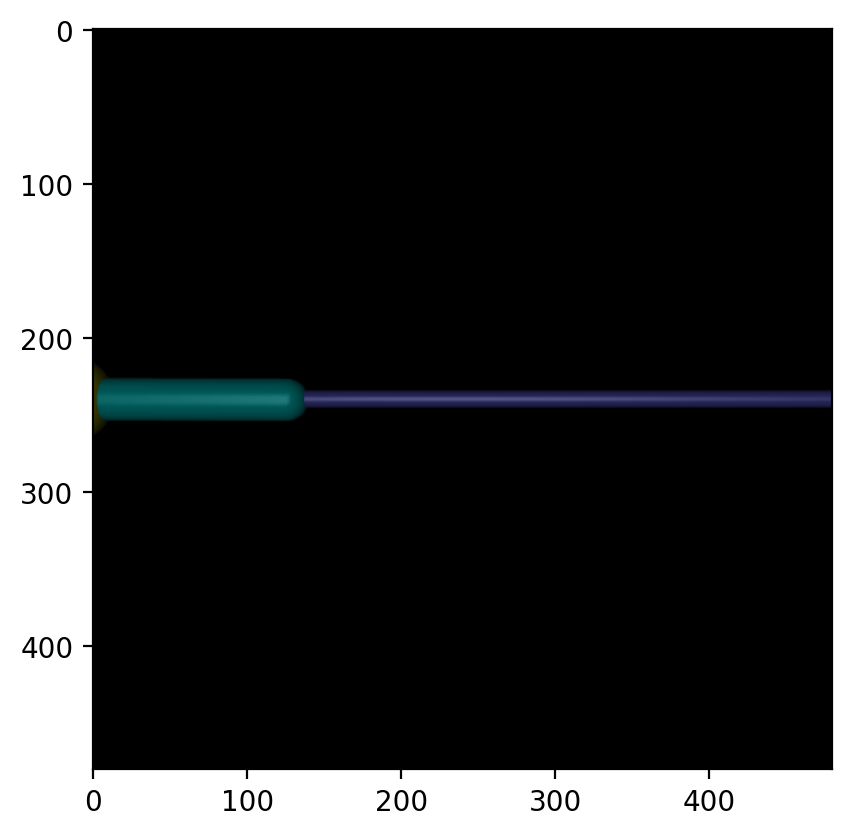

In [61]:
# Now try this policy on the real system
x, _ = env_test.reset()
key, subkey = jr.split(key)
u = control_policy(x,timestep)
# Randomly sample some points
states.append(x)
actions.append(u)
img = plt.imshow(env_test.render()) # only call this once
for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
    z = env_test.step(np.array(u))
    x = z[0]
    r = z[1]
    key, subkey = jr.split(key)
    u = control_policy(x,timestep)
    # states.append(x)
    # actions.append(u)
    print(x)
    print(timestep,r)
    img.set_data(env_test.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [39]:
model = DynamicalModel(states=jnp.array(states),actions=jnp.array(actions))
model.optimize()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [40]:
# Now do a rollout with this model
# Generate an initial state
x, _ = env.reset()
key, subkey = jr.split(key)
# Generate an initial (action
u = exploration_policy(x,timestep,subkey)